# Gambling Demon

In this example, we consider a protocol where a Gambling Demon wants to put work into a system but then wants to extract work via a bit flip. The system is initialised in the ground state, and then applies a $\sigma_{x}$ rotation to the system. 

The work can easily be computed via 
\begin{equation}
\langle W_{T} \rangle = -E_{0} \Omega \int_{0}^{T} \langle \sigma_{y} \rangle dt
\end{equation}
where $\Omega$ is the frequency of the $\sigma_{y}$ is the axis of rotation. From the measured current $I(t) = \sqrt{\Gamma} \langle \sigma_{y} \rangle + \xi(t)$, we can infer the work from the raw integrated current as 
\begin{equation}
 W_{T}  = -E_{0} \Omega \int_{0}^{T} \frac{I(t)}{\sqrt{\Gamma}} dt
\end{equation}

In [71]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from _funcs import *

import seaborn as sns
plt.rc('text', usetex=True)
sns.set()

def get_first_hit(array, x):
    # create a function that returs first hitting time of array >= x
    try: 
        return np.min(np.where(array>=x))
    except ValueError:
        return None


In [366]:
# Parameters
Gamma = 1
Omega = 1
Rabi = np.sqrt((Gamma)**2 + Omega**2)
dt = 0.0012
tf = 5*np.pi/(2*Omega)
t_cutoff = tf/5
t = np.arange(0, tf, dt)

# Define system operators
sp = sigmap()
sm = sigmam()
sx = sigmax()
sz = sigmaz()
sy = sigmay()
g = sm*sp
H = Omega*sx

# define dissipator and Hamiltonian
c_ops = [1j*np.sqrt(Gamma) * sm]    

# steadystate
rho0 = fock(2, 0)
rhoss = steadystate(H, c_ops)

unconditional_result = mesolve(H, rho0, t, c_ops=c_ops, e_ops=[sy, sz, g])
ez_un = unconditional_result.expect[1]
ey_un = unconditional_result.expect[0]
g_un = unconditional_result.expect[2]
N_cutoff = 1
print(tf)
print(N_cutoff)


sp

7.853981633974483
1


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 1.]
 [0. 0.]]

In [306]:
# number of chargers to truncate at 
Nm = 20
dN = 0.06
N = np.arange(-10, Nm, dN)

# ------ Solve n-resolved method with absorbing boundary conditions ------ #
diff = DiffusiveEvolutionPntAbsorb(H, c_ops, 1, t, N, N_cutoff, kind='single')
diff_T = DiffusiveEvolutionPnt(H, c_ops, 1, t, N)
Pn_vec = diff.solve(rho0)
Pn_vec_T = diff_T.solve(rho0)

Converting initial state to vector form


Evolution Superoperator: 100%|██████████| 6544/6544 [00:20<00:00, 317.47it/s]


Converting initial state to vector form


Evolution Superoperator: 100%|██████████| 6544/6544 [00:43<00:00, 151.88it/s]


In [307]:
# Compute survival probability from analytic solution
P0 = np.sum(Pn_vec, axis=0)
dGt = -np.gradient(P0, dt)

# Compute mean and variance of distribution
Et = np.sum(dGt * t)*dt
Var = np.sum(dGt * t**2)*dt - Et**2

np.sum(dGt)*dt

0.8770806675198743

In [237]:
ntraj = 2000
result = ssesolve(H, rho0, t, sc_ops=c_ops, e_ops=[sy, g], store_measurement=True, ntraj=ntraj)

10.0%. Run time:  15.29s. Est. time left: 00:00:02:17
20.0%. Run time:  30.45s. Est. time left: 00:00:02:01
30.0%. Run time:  45.52s. Est. time left: 00:00:01:46
40.0%. Run time:  60.63s. Est. time left: 00:00:01:30
50.0%. Run time:  75.72s. Est. time left: 00:00:01:15
60.0%. Run time:  90.83s. Est. time left: 00:00:01:00
70.0%. Run time: 105.95s. Est. time left: 00:00:00:45
80.0%. Run time: 121.20s. Est. time left: 00:00:00:30
90.0%. Run time: 136.33s. Est. time left: 00:00:00:15
Total run time: 151.46s


In [308]:
# get measurement results

Iy = np.real(np.array(result.measurement).reshape(ntraj, len(t)))

meas = np.real(result.measurement[0].T)[0]
meas_average = np.mean(result.measurement, axis=0).T[0]
ey = np.real(result.expect[0])
ez = np.real(result.expect[1])

int_meas = dt*np.cumsum(meas)
W = -Omega*dt*np.cumsum(Iy, axis=1)/np.sqrt(Gamma)
int_ey = dt*np.cumsum(ey)

# get first hitting time of measurement
indx = get_first_hit(int_meas, N_cutoff)
if indx is None:
    first_hit = tf
else:
    first_hit = t[indx]

# Get first hitting times
inds = np.array([get_first_hit(mi, N_cutoff) for mi in -W])
inds = inds[inds != None]

# Get first hitting times
hitting_times = t[list(inds)]

In [309]:
idx_W = np.argmin(np.abs(t - tf/5))

# Integrate first hitting time distribution to t_cutoff
PT = np.sum(dGt[t<t_cutoff])*dt
N_min = np.argmin(np.abs(N+N_cutoff))
Wbar = -np.sum(N[N_min:]*Pn_vec_T[N_min:, idx_W])
W_T = N_cutoff * PT +(1-PT) * Wbar

N_th = PT + 

0.3230034114785307

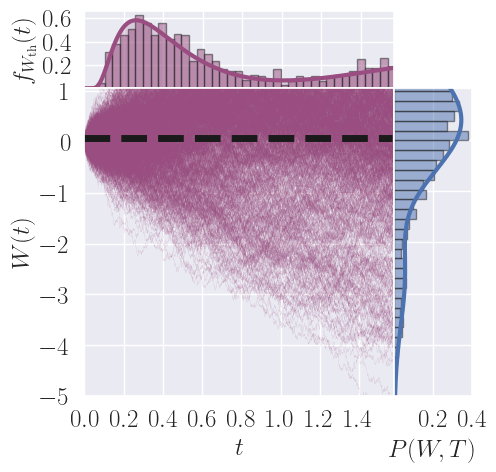

In [364]:
fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(5, 5)

color = [0.6, 0.3, 0.5]
fs = 18

ax1 = fig.add_subplot(gs[0, :4])
ax1.plot(t, dGt, color=color, linewidth=3)
ax1.fill_between(t, dGt, color=color, alpha=0.2)
ax1.hist(hitting_times, bins=200, color=color, alpha=0.5, density=True, edgecolor='k')

plt.xticks(np.arange(0, tf, 0.2), [])
plt.xlim(0, t_cutoff)
plt.yticks(np.arange(0.2, 0.7, 0.2), fontsize=fs)
plt.ylabel(r'$f_{W_{\rm th}}(t)$', fontsize=fs)

ax2 = fig.add_subplot(gs[1:5, :4])
ax2.plot(t, W[:1000].T, color=color, linewidth=0.05, alpha=1)
# plt.vlines(t_cutoff, -5, N_cutoff, color='b', linewidth=5, linestyle='--')
# plt.hlines(N_cutoff, 0, t_cutoff, color=color, linewidth=5, linestyle='--')
plt.hlines(W_T, 0, t_cutoff, color='k', linewidth=5, linestyle='--')

plt.ylim(-5, N_cutoff+0.05)
plt.yticks(np.arange(-5, N_cutoff+1, 1), fontsize=fs)
plt.xticks(np.arange(0, t_cutoff, 0.2), fontsize=fs)
plt.xlim(0, t_cutoff+0.01)
plt.ylabel(r'$W(t)$', fontsize=fs)
plt.xlabel(r'$t$', fontsize=fs)

ax3 = fig.add_subplot(gs[1:, 4])
ax3.plot(Pn_vec_T[:, idx_W]/dN, -N, color='b', linewidth=3)
ax3.hist(W[:, idx_W], bins=50, orientation='horizontal', color='b', alpha=0.5, density=True, edgecolor='k')
plt.yticks(np.arange(-5, N_cutoff+1, 1),[])
plt.ylim(-5, N_cutoff)
plt.xticks(np.arange(0.2, 0.5, 0.2), fontsize=fs)

plt.xlabel(r'$P(W, T)$', fontsize=fs)
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

fig.savefig('Figures/Gambling_demon_mean.png', bbox_inches='tight', dpi=200)


(-1.0, 1.0)

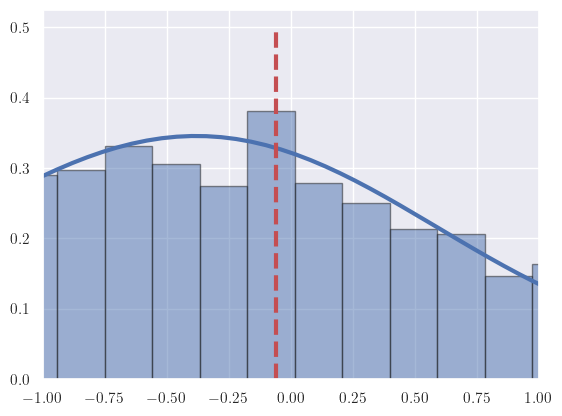

In [338]:
plt.plot(N, Pn_vec_T[:, idx_W]/dN, color='b', linewidth=3)
Wmean = np.sum(N*Pn_vec_T[:, idx_W])
plt.vlines(Wmean, 0, 0.5, color='r', linewidth=3, linestyle='--')
plt.hist(-W[:, idx_W], bins=50, color='b', alpha=0.5, density=True, edgecolor='k')

plt.xlim(-1, 1)

In [332]:
N_th = 

0.09853449850017205

In [335]:
Wmean

-0.05743545138759023